
# Comparing Carbon Emission from `CNNs`

Return to the [Castle](https://github.com/Nkluge-correa/teeny-tiny_castle)

**Training Convolutional Neural Networks (CNNs) for computer vision involves a significant amount of computational resources, the use of powerful processors, high-end graphics cards, and other hardware components that consume energy (_data centers that house these resources also require a significant amount of energy to operate and maintain_), which in turn can result in carbon emissions.** 

> **Carbon emissions are sometimes referred to as carbon footprint. A carbon footprint is the total greenhouse gas (GHG) emissions caused by an individual, event, organization, service, place, or product, expressed in carbon dioxide equivalent ($CO_{2}e$).**

**The carbon emissions associated with training CNNs can vary depending on factors such as the size of the network, the length of the training process, and the energy efficiency of the hardware used. Currently, efforts are being made to develop more energy-efficient hardware and optimize training algorithms to reduce carbon emissions associated with training CNNs for computer vision. Something that is usually debated under the umbrella term of "_Sustaineble AI_".**

> **For more information on the matter (Sustainable Computer Vision), we recommend "_[Highlighting the Importance of Reducing Research Bias and Carbon Emissions in CNNs](https://arxiv.org/abs/2106.03242)_".** 

<img src="https://lh5.googleusercontent.com/prAfirs8L4UBqWWkX9dPoAEQwYHIJ0CLR9sUDNSrRMC44R3vXaQfGFycHjq68rT6Z5_B6sJJ9jlQmhun0adWX2BBfVFr6BZ8OFTXQskjPNqTBkPfl5ysmdMinxn7CPEgkGoXL1hT=s0" alt="image" width="600">

**Source: _[The Imperative for Sustainable AI Systems](https://thegradient.pub/sustainable-ai/)._**

**For this tutorial, we want to create a comparison between different CNN architectures, to promote a "Sustainable versus Roubust" dilemma. We will be comparing how architectural choices can impact the carbon footprint related to training such models. We will be using the [`CodeCarbon`](https://github.com/mlco2/codecarbon) for measuring this footprint, a library that enables the creation of $CO_{2}$ Emission Reports, as already demonstrated in [this notebook](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/d4c39ce985c3abb5698e390ae3c3f369046e4efc/ML%20Accountability/CO2%20Emission%20Report/emission_tracker.ipynb).**

> **$CO_{2}$ Emission Reports are simple transparency tools that help developers make public (and thus become accountable) the ($CO_{2}e$) production associated with the training of an ML model.**

**We have choosen the [Chest X-Ray Pneumonia](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) Dataset as our classification problem. This dataset comes organized into 3 folders (`train`, `test`, `val`) and contains subfolders for each image category (Pneumonia/Normal), summing to 5,863 X-Ray images in JPEG format from pediatric patients from Guangzhou Women and Children’s Medical Center.**

**After downloading the [Chest X-Ray Pneumonia](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) dataset, you can pre-load them in your environment using the `tf.keras.utils.image_dataset_from_directory` utility.**

> **`tf.keras.utils.image_dataset_from_directory` is a utility function in TensorFlow Keras that creates a tf.data.Dataset object from a directory of image files. The `batch_size` parameter specifies how many images are in each batch, and the `image_size` parameter sets the dimensions of each image.**

In [2]:
import tensorflow as tf

train_dataset = tf.keras.utils.image_dataset_from_directory(
 "data/chest_xray/train",
 image_size=(128, 128),
 batch_size=32)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
 "data/chest_xray/val",
 image_size=(128, 128),
 batch_size=32)
test_dataset = tf.keras.utils.image_dataset_from_directory(
 "data/chest_xray/test",
 image_size=(128, 128),
 batch_size=32)

print('-'*50)
for data_batch, labels_batch in train_dataset:
    print("Data Batch Shape:", data_batch.shape)
    print("Labels Batch Shape:", labels_batch.shape)
    break

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
--------------------------------------------------
Data Batch Shape: (32, 128, 128, 3)
Labels Batch Shape: (32,)


**Let us now plot some of our images, so we can know what are we trying to classify. Below we have a sample of one pneumonia-baring patient and a healthy one.**

**Pneumonia is a serious respiratory infection that can affect children of all ages but is most common in infants and young children. This infection can be caused by various microorganisms, including bacteria, viruses, and fungi. The most common bacterial cause of pneumonia in children is "_[Streptococcus pneumoniae](https://en.wikipedia.org/wiki/Streptococcus_pneumoniae)_," also known as pneumococcus.**

**Pneumonia can be particularly dangerous in children because their immune systems are still developing, making them more susceptible to infections. In severe cases, pneumonia can lead to respiratory failure, sepsis, or other complications that can be life-threatening. ML can help prevent deadly pneumonia cases in several ways. For example, ML models can be used to analyze medical images, such as chest X-rays and CT scans, to assist in the diagnosis of pneumonia. Early detection is vital to prevent dier outcomes.**

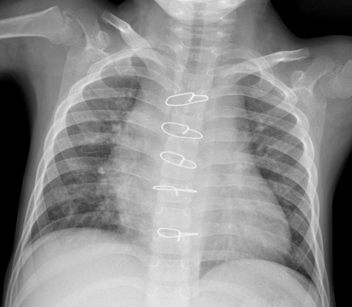

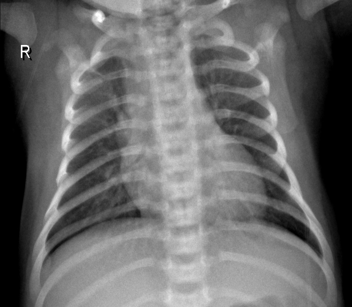

In [2]:
from PIL import Image

pneumonia = Image.open('data/chest_xray/train/PNEUMONIA/person13_bacteria_50.jpeg')
normal = Image.open('data/chest_xray/train/NORMAL/IM-0158-0001.jpeg')

width, height = pneumonia.size
new_size = (width//5, height//5) 

pneumonia = pneumonia.resize(new_size)
normal = normal.resize(new_size)

display(pneumonia)
display(normal)


**We will now be training three different `convolutional neural networks` with different architectures to understand how architectural choices can influence the carbon footprint and performance of `CNNs`.  These networks are not optimized but serve as a starting point for further analysis.**

**`CNNs` are widely used in many computer vision tasks, such as image classification, object detection, and segmentation, but training them can be computationally expensive and energy-intensive. The three `CNN` architectures that we will be training are:**

- **A standard multi-layered deep CNN, using `Conv2D` layers.**
- **An Inception network, using both `Conv2D` and `SeparableConv2D` layers, together with residual connections and `BatchNormalization` layers.**
- **Finally, we will train a CNN using only `SeparableConv2D`.**

> **To learn more about `Inception`, we recommend the original article, "_[Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/abs/1610.02357)_."**

**By comparing the carbon footprint and performance of these three `CNN` architectures, we can gain insights into how different architectural choices can decrease the environmental impact of machine learning models. This information can help us make more informed decisions about how to design and train systems that are both effective and sustainable.**

**To standardize our comparison, will train all three networks for the same amount of time, with no `EarlyStopping`. And to track the energy consumption of these models we will use the `EmissionsTracker` class from [CodeCarbon](https://github.com/mlco2/codecarbon). Here are some arguments you can pass the `EmissionsTracker`:**

- **`project_name`: This is a string that identifies the project or model being trained.**
- **`log_level`: This sets the level of logging for the EmissionsTracker instance. The possible values are `debug`, `info`, `warning`, `error`, and `critical` (use `critical` if you want less noise on your screen).** 
- **`output_file`: This is a string that specifies the name of the CSV file where the emissions data will be stored.** 

**For more information, check the [documentaion](https://mlco2.github.io/codecarbon/parameters.html).**

**If you do not want to train these models, we made available all of them, paired with their respective $CO_2$ emissions report, for [download in this link](https://drive.google.com/uc?export=download&id=1CtXfDGrM_-ZvC8vwV2MgTQLlxopv4F8f). Thus, you can jump for the last cells to perform the comparison (and help the environment). Just follow the download instructions in the `models` folder**

In [3]:
from codecarbon import EmissionsTracker

tracker = EmissionsTracker(
    project_name="conv2d_emissions",
    log_level="critical",
    output_dir="models",
    output_file="conv2d_emissions.csv",
)

EPOCHS = 20

inputs = tf.keras.Input(shape=(128, 128, 3)) 
x = tf.keras.layers.Rescaling(1./255)(inputs) 

x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, 
                           strides=2, padding ='same', 
                           activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, 
                           strides=2, padding='same', 
                           activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, 
                           strides=2, padding='same',
                           activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation = "relu")(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) 

cnn_conv2d = tf.keras.Model(inputs=inputs, outputs=outputs)

cnn_conv2d.compile(loss="binary_crossentropy", optimizer="adam",  
               metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "models/Conv2D.keras",
            save_best_only=True),  
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=3),
]

print("TensorFlow version:", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
cnn_conv2d.summary()

tracker.start()

cnn_conv2d.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset, 
    verbose=1,
    callbacks=callbacks)

tracker.stop()

cnn_conv2d = tf.keras.models.load_model("models/Conv2D.keras")

loss, acc = cnn_conv2d.evaluate(test_dataset, verbose=0)

print(f'CNN_Conv2D Loss: {round(loss, 2)}')
print(f'CNN_Conv2D Performance: {round(acc * 100, 2)} %')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                      

**Now, let us train our Inception model.**

**The Xception architecture uses a series of residual connections and bypasses to improve the flow of information through the network and prevent vanishing gradients. The below network is much deeper than the last one (_it has many more layers_) and uses a combination of `Conv2D` and `SeparableConv2D` as its convolutional layers.**

**If you want, you can definitely make this network deeper, with more layers and filters. Something that is bound to improve performance in some way** 

**But now, let us create the "_blocks_" that form our network.**

In [4]:
from codecarbon import EmissionsTracker

tracker = EmissionsTracker(
    project_name="xception_emissions",
    log_level="critical",
    output_dir="models",
    output_file="xception_emissions.csv",
)

EPOCHS = 20

def conv_2d_base(x, filters, kernel_size, strides=1):
    """
    Convolutional 2D layer followed by batch normalization.
    
    Args:
        x: Input tensor of shape (batch_size, height, width, channels).
        filters: Integer, the dimensionality of the output space (i.e., 
            the number of output filters in the convolution).
        kernel_size: An integer or tuple/list of 2 integers, specifying 
            the height and width of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers, specifying the 
            strides of the convolution along the height and width dimensions 
            (Default is 1).
        
    Returns:
        A tensor of shape (batch_size, new_height, new_width, filters), 
        where new_height and new_width depend on the input size, kernel size, 
        strides, and padding.
    """
    
    x = tf.keras.layers.Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

def sep_conv_2d_base(x, filters, kernel_size, strides=1):
    """
    Separable 2D convolution layer followed by batch normalization.
    
    Args:
        x: Input tensor of shape (batch_size, height, width, channels).
        filters: Integer, the dimensionality of the output space (i.e., the 
            number of output filters in the convolution).
        kernel_size: An integer or tuple/list of 2 integers, specifying the height 
            and width of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers, specifying the 
            strides of the convolution along the height and width dimensions 
            (Default is 1).
        
    Returns:
        A tensor of shape (batch_size, new_height, new_width, filters), where 
        new_height and new_width depend on the input size, kernel size, 
        strides, and padding.
    """
    
    x = tf.keras.layers.SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

def entry_flow_xception(x):
    """
        Entry flow block of the Xception model.
    
    Args:
        x: Input tensor of shape (batch_size, height, width, channels).
        
    Returns:
        A tensor of shape (batch_size, new_height, new_width, filters), 
        where new_height and new_width depend on the input size, kernel 
        size, strides, and padding.

    """
    
    x = conv_2d_base(x, filters =32, kernel_size =3, strides=2)
    x = tf.keras.layers.ReLU()(x)
    x = conv_2d_base(x, filters =32, kernel_size =3, strides=1)
    tensor = tf.keras.layers.ReLU()(x)
    
    x = sep_conv_2d_base(tensor, filters = 64, kernel_size =3)
    x = tf.keras.layers.ReLU()(x)
    x = sep_conv_2d_base(x, filters = 64, kernel_size =3)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_2d_base(tensor, filters=64, kernel_size = 1,strides=2)
    x = tf.keras.layers.Add()([tensor,x])
    
    x = tf.keras.layers.ReLU()(x)
    x = sep_conv_2d_base(x, filters =128, kernel_size=3)
    x = tf.keras.layers.ReLU()(x)
    x = sep_conv_2d_base(x, filters =128, kernel_size=3)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_2d_base(tensor, filters=128, kernel_size = 1,strides=2)
    x = tf.keras.layers.Add()([tensor,x])
    
    return x

def middle_flow_xception(tensor):
    """
        Entry flow block of the Xception model.
    
    Args:
        x: Input tensor of shape (batch_size, height, width, channels).
        
    Returns:
        A tensor of shape (batch_size, new_height, new_width, filters), 
        where new_height and new_width depend on the input size, kernel size, 
        strides, and padding.

    """
    
    for _ in range(8):
        x = tf.keras.layers.ReLU()(tensor)
        x = sep_conv_2d_base(x, filters = 128, kernel_size = 3)
        x = tf.keras.layers.ReLU()(x)
        x = sep_conv_2d_base(x, filters = 128, kernel_size = 3)
        x = tf.keras.layers.ReLU()(x)
        x = sep_conv_2d_base(x, filters = 128, kernel_size = 3)
        x = tf.keras.layers.ReLU()(x)
        tensor = tf.keras.layers.Add()([tensor,x])
        
    return tensor

def exit_flow_xception(tensor):
    """
    This function implements the exit flow of the Xception model. 
    It takes a tensor as input and applies a series of convolutional, 
    pooling, and dense layers to produce a binary classification output.

    Args:
        tensor: Input tensor to the exit flow.

    Returns:
        Output tensor after passing through the exit flow.

    """
    
    x = tf.keras.layers.ReLU()(tensor)
    x = sep_conv_2d_base(x, filters = 128,  kernel_size=3)
    x = tf.keras.layers.ReLU()(x)
    x = sep_conv_2d_base(x, filters = 256,  kernel_size=3)
    x = tf.keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_2d_base(tensor, filters =256, kernel_size=1, strides =2)
    x = tf.keras.layers.Add()([tensor,x])
    
    x = sep_conv_2d_base(x, filters = 512,  kernel_size=3)
    x = tf.keras.layers.ReLU()(x)
    x = sep_conv_2d_base(x, filters = 1024,  kernel_size=3)
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    x = tf.keras.layers.Dense (units = 1, activation = 'sigmoid')(x)
    return x


**Now, we can finally build and train our mini Inception network.**

In [3]:

input = tf.keras.layers.Input(shape = (128,128,3))
x = entry_flow_xception(input)
x = middle_flow_xception(x)
output = exit_flow_xception(x)

xception = tf.keras.Model (inputs=input, outputs=output)

xception.compile(loss="binary_crossentropy", optimizer="adam",  
               metrics=["accuracy"])

print("TensorFlow version:", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
xception.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "models/xception.keras",
            save_best_only=True),  
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=3),
]

tracker.start()

xception.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset, 
    verbose=1,
    callbacks=callbacks)

tracker.stop()

xception = tf.keras.models.load_model("models/xception.keras")

loss, acc = xception.evaluate(test_dataset, verbose=0)

print(f'Xception Loss: {round(loss, 2)}')
print(f'Xception Performance: {round(acc * 100, 2)} %')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

**Now, let us train the same network we trained in the first round, using only `SeparableConv2D` layers instead of `Conv2D`. `SeparableConv2D` also play an important part in the `Inception` architecture, but now we will use them without the standard combination that we find in `Inception` networks.**

**The advantage of using `SeparableConv2D` is that it can reduce the number of parameters in the model by using a smaller number of filters in each operation. But how do we do that?**

**There are two types of separable convolutions: spatial separable convolutions and depthwise separable convolutions. Spatial separable convolutions help us diminish the number of multiplications in our convolution operation. These separable convolutions divide a kernel into two (e.g., in RGB images, this would be the spatial kernel and the channel kernel). For example, instead of using a 3x3 kernel, we could use two 3x1 kernels instead (6 multiplications are less than one).**

$$\begin{bmatrix} 3 & 6 & 9 \\ 4 & 8 & 12 \\ 5 & 10 & 15 \end{bmatrix} = \begin{bmatrix} 3 \\ 4 \\ 5 \end{bmatrix} \times \begin{bmatrix} 1 & 2 & 3 \end{bmatrix}$$

**The primary limitation of spatial separable convolution is that not all kernels can be "_divided_" into two smaller kernels. Depthwise separable convolutions, as opposed to spatial separable convolutions, work with kernels that cannot be "_factored_" into two smaller kernels. As a result, it is more commonly used in deep learning.**

**Depthwise separable convolution also separates the kernel into two: the depthwise convolution and the pointwise convolution. In the end, producing a similar effect (reducing the number of multiplications needed). Less multiplication $=$ faster computation.**

**To learn more about this subject, we recommend the [following explanation](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728), by Chi-Feng Wang.** 

In [4]:
from codecarbon import EmissionsTracker

tracker = EmissionsTracker(
    project_name="separable_conv2d_emissions",
    log_level="critical",
    output_dir="models",
    output_file="separable_conv2d_emissions.csv",
)

EPOCHS = 20

inputs = tf.keras.Input(shape=(128, 128, 3)) 
x = tf.keras.layers.Rescaling(1./255)(inputs) 

x = tf.keras.layers.SeparableConv2D(filters=32, kernel_size=3, 
                           strides=2, padding ='same', 
                           activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.SeparableConv2D(filters=64, kernel_size=3, 
                           strides=2, padding='same', 
                           activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.SeparableConv2D(filters=128, kernel_size=3, 
                           strides=2, padding='same',
                           activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation = "relu")(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) 

separable_conv2d = tf.keras.Model(inputs=inputs, outputs=outputs)

separable_conv2d.compile(loss="binary_crossentropy", optimizer="adam",  
               metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "models/Separable_conv2d.keras",
            save_best_only=True),  
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=3),
]

print("TensorFlow version:", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
separable_conv2d.summary()

tracker.start()

separable_conv2d.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset, 
    verbose=1,
    callbacks=callbacks)

tracker.stop()

separable_conv2d = tf.keras.models.load_model("models/Separable_conv2d.keras")

loss, acc = separable_conv2d.evaluate(test_dataset, verbose=0)

print(f'Separable_conv2d Loss: {round(loss, 2)}')
print(f'Separable_conv2d Performance: {round(acc * 100, 2)} %')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 separable_conv2d_4 (Separab  (None, 64, 64, 32)       155       
 leConv2D)                                                       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 separable_conv2d_5 (Separab  (None, 16, 16, 64)       2400      
 leConv2D)                                                       
                                                           

**Now we have 3 trained models paired with 3 energy consumption reports. Let's now compare these results and a little table.** 

In [26]:
from IPython.display import Markdown
import pandas as pd

# Read the CSV files
df_xception = pd.read_csv("carbon_emissions/xception_emissions.csv")
df_cnn_conv2d = pd.read_csv("carbon_emissions/conv2d_emissions.csv")
df_separable_conv2d = pd.read_csv("carbon_emissions/separable_conv2d_emissions.csv")

# Load the models
xception = tf.keras.models.load_model("models/xception.keras")
cnn_conv2d = tf.keras.models.load_model("models/Conv2D.keras")
separable_conv2d = tf.keras.models.load_model("models/Separable_conv2d.keras")

# Evaluate the models
conv2d_loss, conv2d_acc = cnn_conv2d.evaluate(test_dataset, verbose=0)
xception_loss, xception_acc = xception.evaluate(test_dataset, verbose=0)
sepconv_loss, sepconv_acc = separable_conv2d.evaluate(test_dataset, verbose=0)

# Create a dataframe with the combined results
df_cnn_conv2d['accuracy'] = conv2d_acc
df_cnn_conv2d['loss'] = conv2d_loss
df_cnn_conv2d.index = ['Conv2d']
df_cnn_conv2d = df_cnn_conv2d[['accuracy','loss','duration','energy_consumed',
                    'emissions','emissions_rate']]

df_xception['accuracy'] = xception_acc
df_xception['loss'] = xception_loss
df_xception.index = ['Xception']
df_xception = df_xception[['accuracy','loss','duration','energy_consumed',
                  'emissions','emissions_rate']]


df_separable_conv2d['accuracy'] = sepconv_acc
df_separable_conv2d['loss'] = sepconv_loss
df_separable_conv2d.index = ['Separable_conv2d']
df_separable_conv2d = df_separable_conv2d[['accuracy','loss','duration','energy_consumed',
                          'emissions','emissions_rate']]

# Concatenate the dataframes and display the results
df = pd.concat([df_cnn_conv2d, df_xception, df_separable_conv2d])
display(Markdown(df.sort_values('emissions').to_markdown()))


|                  |   accuracy |     loss |   duration |   energy_consumed |   emissions |   emissions_rate |
|:-----------------|-----------:|---------:|-----------:|------------------:|------------:|-----------------:|
| Conv2d           |   0.814103 | 0.724595 |    269.635 |        0.00193918 | 0.000583693 |       0.00216475 |
| Separable_conv2d |   0.839744 | 0.517222 |    281.071 |        0.00202138 | 0.000608437 |       0.00216471 |
| Xception         |   0.81891  | 0.846412 |    748.036 |        0.00538037 | 0.00161949  |       0.00216499 |

**The simplest `Conv2D` network loses accuracy but wins in terms of energy efficiency and training speed. The `Xception` model promotes a marginal increase in performance ($0.4\%$) but has twice the emissions and nearly three times the energy consumption. Deeper is not better in this case. The `Separable conv2d` produces a minor increase in training duration and emissions, but nearly a $3\%$ increase in accuracy.**

**However, it is not clear how to balance these tradeoffs, and we arrive at a dilemma.**

> **How to deal with the tradeoff between accuracy and sustainability, if low accuracy means that children with pneumonia will possibly receive false negative results?**

**If we built a deeper `Xception` network, for example, or performed transfer learning with a more robust neural network (like Imagenet), this would maybe improve accuracy when compared to our lightweight `Separable conv2d`. More performance can reduce the likelihood of a child receiving an incorrect diagnosis. Unfortunately, greater efficiency (at times) implies more parameters, multiplications, and overall computation.**

**We do not have answers to these questions, but the field of CV is working to optimize our current techniques to reduce their environmental footprint. When discussing sustainability in ML for medical applications, two values sometimes collide intergenerational justice (to be fair to those who haven't yet arrived) and beneficence/non-maleficence. What would you choose? 🤔**

---

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).